# Other neural network examples

Here we will show a couple of other examples for neural networks, these are more advanced though

In [1]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Conv2D, Flatten, Reshape, Conv2DTranspose, Activation, LSTM, Conv1D, GlobalMaxPooling1D, Embedding
from keras.callbacks import TensorBoard, ModelCheckpoint
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing import sequence

from keras.datasets import imdb

%matplotlib inline

Using TensorFlow backend.


## Sequence prediction with LSTM

Neural networks can also work with sequences. Sequences are typically modeled with Recurent Neural Networks. These have connections between neurons within one layer, allowing them to preserve state from before and use it in the next prediction. Lets load and explore some data first.

You can find more datasets at https://datamarket.com/data/list/?q=cat:g22%20provider:tsdl

In [16]:
# dataset = np.loadtxt('datasets/normalized_apple_prices.csv')
dataset = np.loadtxt('datasets/ibm-common-stock-closing-prices-.csv', usecols=(1,), skiprows=1, delimiter=',')

We need to scale the data into interval 0 - 1, to help the neural network optimize for the data

In [17]:
dataset = dataset.reshape(-1, 1)
# dataset_2.shape
scaler = MinMaxScaler()
scaler.fit(dataset)
dataset = scaler.transform(dataset)

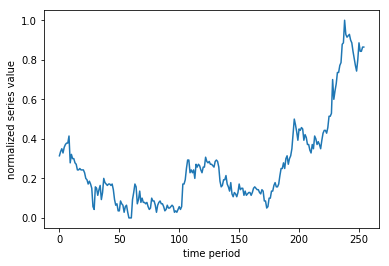

In [18]:
# lets take a look at our time series
plt.plot(dataset)
plt.xlabel('time period')
plt.ylabel('normalized series value')

We need to preprocess our dataset, with the following idea in mind:
1. The neural network will take small part of the sequence (e.g. 7 continuous values) as input
2. It will predict the next value based on this window

Therefore we take the dataset, make the windows and expected predictions for each window (the next number in the sequence)

In [19]:
window_size = 7
X = np.array([dataset[i:i+window_size] for i in range(0, len(dataset) - window_size)])
y = np.array([dataset[i] for i in range(7, len(dataset))])

In [20]:
print(X[0])
print(y[0])

[[0.31428571]
 [0.33571429]
 [0.35      ]
 [0.32857143]
 [0.35714286]
 [0.37142857]
 [0.37857143]]
[0.37857143]


In [21]:
print(X[2])
print(y[2])

[[0.35      ]
 [0.32857143]
 [0.35714286]
 [0.37142857]
 [0.37857143]
 [0.37857143]
 [0.41428571]]
[0.27857143]


In [22]:
train_test_split = int(np.ceil(2*len(y)/float(3)))   # set the split point

# partition the training set
X_train = X[:train_test_split]
y_train = y[:train_test_split]

# keep the last chunk for testing
X_test = X[train_test_split:]
y_test = y[train_test_split:]

# reshape the imput for LSTM layer [samples, window size, stepsize] 
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

In [23]:
model = Sequential()

model.add(LSTM(5, input_shape=(window_size, 1)))
model.add(Dense(1))


In [24]:
# build model using keras documentation recommended optimizer initialization
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# compile the model
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [25]:
model.fit(X_train, y_train, epochs=1000, batch_size=50, verbose=1)

Epoch 1/1000
166/166 [==============================] - 1s 5ms/step - loss: 0.0225
Epoch 2/1000
166/166 [==============================] - 0s 238us/step - loss: 0.0145
Epoch 3/1000
166/166 [==============================] - 0s 238us/step - loss: 0.0105
Epoch 4/1000
166/166 [==============================] - 0s 236us/step - loss: 0.0080
Epoch 5/1000
166/166 [==============================] - 0s 238us/step - loss: 0.0064
Epoch 6/1000
166/166 [==============================] - 0s 233us/step - loss: 0.0053
Epoch 7/1000
166/166 [==============================] - 0s 227us/step - loss: 0.0046
Epoch 8/1000
166/166 [==============================] - 0s 246us/step - loss: 0.0041
Epoch 9/1000
166/166 [==============================] - 0s 240us/step - loss: 0.0038
Epoch 10/1000
166/166 [==============================] - 0s 229us/step - loss: 0.0036
Epoch 11/1000
166/166 [==============================] - 0s 233us/step - loss: 0.0035
Epoch 12/1000
166/166 [==============================] - 0s 237us

166/166 [==============================] - 0s 209us/step - loss: 0.0014
Epoch 97/1000
166/166 [==============================] - 0s 202us/step - loss: 0.0014
Epoch 98/1000
166/166 [==============================] - 0s 204us/step - loss: 0.0014
Epoch 99/1000
166/166 [==============================] - 0s 236us/step - loss: 0.0014
Epoch 100/1000
166/166 [==============================] - 0s 219us/step - loss: 0.0014
Epoch 101/1000
166/166 [==============================] - 0s 221us/step - loss: 0.0014
Epoch 102/1000
166/166 [==============================] - 0s 214us/step - loss: 0.0014
Epoch 103/1000
166/166 [==============================] - 0s 214us/step - loss: 0.0014
Epoch 104/1000
166/166 [==============================] - 0s 222us/step - loss: 0.0014
Epoch 105/1000
166/166 [==============================] - 0s 215us/step - loss: 0.0014
Epoch 106/1000
166/166 [==============================] - 0s 223us/step - loss: 0.0014
Epoch 107/1000
166/166 [==============================] - 0s 

166/166 [==============================] - 0s 213us/step - loss: 0.0012
Epoch 191/1000
166/166 [==============================] - 0s 183us/step - loss: 0.0012
Epoch 192/1000
166/166 [==============================] - 0s 210us/step - loss: 0.0012
Epoch 193/1000
166/166 [==============================] - 0s 184us/step - loss: 0.0013
Epoch 194/1000
166/166 [==============================] - 0s 201us/step - loss: 0.0012
Epoch 195/1000
166/166 [==============================] - 0s 192us/step - loss: 0.0013
Epoch 196/1000
166/166 [==============================] - 0s 193us/step - loss: 0.0012
Epoch 197/1000
166/166 [==============================] - 0s 198us/step - loss: 0.0012
Epoch 198/1000
166/166 [==============================] - 0s 190us/step - loss: 0.0012
Epoch 199/1000
166/166 [==============================] - 0s 207us/step - loss: 0.0012
Epoch 200/1000
166/166 [==============================] - 0s 202us/step - loss: 0.0012
Epoch 201/1000
166/166 [==============================] - 

166/166 [==============================] - 0s 211us/step - loss: 0.0012
Epoch 285/1000
166/166 [==============================] - 0s 209us/step - loss: 0.0011
Epoch 286/1000
166/166 [==============================] - 0s 224us/step - loss: 0.0011
Epoch 287/1000
166/166 [==============================] - 0s 214us/step - loss: 0.0011
Epoch 288/1000
166/166 [==============================] - 0s 213us/step - loss: 0.0011
Epoch 289/1000
166/166 [==============================] - 0s 204us/step - loss: 0.0012
Epoch 290/1000
166/166 [==============================] - 0s 212us/step - loss: 0.0011
Epoch 291/1000
166/166 [==============================] - 0s 213us/step - loss: 0.0011
Epoch 292/1000
166/166 [==============================] - 0s 207us/step - loss: 0.0011
Epoch 293/1000
166/166 [==============================] - 0s 210us/step - loss: 0.0011
Epoch 294/1000
166/166 [==============================] - 0s 206us/step - loss: 0.0011
Epoch 295/1000
166/166 [==============================] - 

166/166 [==============================] - 0s 177us/step - loss: 0.0011
Epoch 379/1000
166/166 [==============================] - 0s 176us/step - loss: 0.0011
Epoch 380/1000
166/166 [==============================] - 0s 198us/step - loss: 0.0011
Epoch 381/1000
166/166 [==============================] - 0s 200us/step - loss: 0.0011
Epoch 382/1000
166/166 [==============================] - 0s 197us/step - loss: 0.0011
Epoch 383/1000
166/166 [==============================] - 0s 197us/step - loss: 0.0011
Epoch 384/1000
166/166 [==============================] - 0s 204us/step - loss: 0.0011
Epoch 385/1000
166/166 [==============================] - 0s 206us/step - loss: 0.0011
Epoch 386/1000
166/166 [==============================] - 0s 193us/step - loss: 0.0011
Epoch 387/1000
166/166 [==============================] - 0s 195us/step - loss: 0.0011
Epoch 388/1000
166/166 [==============================] - 0s 193us/step - loss: 0.0011
Epoch 389/1000
166/166 [==============================] - 

166/166 [==============================] - 0s 183us/step - loss: 0.0011
Epoch 473/1000
166/166 [==============================] - 0s 178us/step - loss: 0.0010
Epoch 474/1000
166/166 [==============================] - 0s 183us/step - loss: 0.0011
Epoch 475/1000
166/166 [==============================] - 0s 207us/step - loss: 0.0010
Epoch 476/1000
166/166 [==============================] - 0s 197us/step - loss: 0.0010
Epoch 477/1000
166/166 [==============================] - 0s 205us/step - loss: 0.0011
Epoch 478/1000
166/166 [==============================] - 0s 195us/step - loss: 0.0010
Epoch 479/1000
166/166 [==============================] - 0s 209us/step - loss: 0.0011
Epoch 480/1000
166/166 [==============================] - 0s 217us/step - loss: 0.0011
Epoch 481/1000
166/166 [==============================] - 0s 207us/step - loss: 0.0010
Epoch 482/1000
166/166 [==============================] - 0s 214us/step - loss: 0.0011
Epoch 483/1000
166/166 [==============================] - 

166/166 [==============================] - 0s 195us/step - loss: 0.0010
Epoch 567/1000
166/166 [==============================] - 0s 188us/step - loss: 0.0010
Epoch 568/1000
166/166 [==============================] - 0s 192us/step - loss: 0.0010
Epoch 569/1000
166/166 [==============================] - 0s 220us/step - loss: 0.0010
Epoch 570/1000
166/166 [==============================] - 0s 222us/step - loss: 0.0010
Epoch 571/1000
166/166 [==============================] - 0s 210us/step - loss: 0.0010
Epoch 572/1000
166/166 [==============================] - 0s 211us/step - loss: 0.0010
Epoch 573/1000
166/166 [==============================] - 0s 214us/step - loss: 0.0011
Epoch 574/1000
166/166 [==============================] - 0s 205us/step - loss: 0.0010
Epoch 575/1000
166/166 [==============================] - 0s 207us/step - loss: 0.0011
Epoch 576/1000
166/166 [==============================] - 0s 214us/step - loss: 0.0010
Epoch 577/1000
166/166 [==============================] - 

166/166 [==============================] - 0s 221us/step - loss: 0.0010
Epoch 661/1000
166/166 [==============================] - 0s 224us/step - loss: 0.0011
Epoch 662/1000
166/166 [==============================] - 0s 221us/step - loss: 0.0010
Epoch 663/1000
166/166 [==============================] - 0s 217us/step - loss: 0.0010
Epoch 664/1000
166/166 [==============================] - 0s 210us/step - loss: 0.0010
Epoch 665/1000
166/166 [==============================] - 0s 209us/step - loss: 0.0010
Epoch 666/1000
166/166 [==============================] - 0s 209us/step - loss: 0.0010
Epoch 667/1000
166/166 [==============================] - 0s 201us/step - loss: 0.0010
Epoch 668/1000
166/166 [==============================] - 0s 205us/step - loss: 0.0010
Epoch 669/1000
166/166 [==============================] - 0s 212us/step - loss: 0.0010
Epoch 670/1000
166/166 [==============================] - 0s 208us/step - loss: 0.0011
Epoch 671/1000
166/166 [==============================] - 

166/166 [==============================] - 0s 185us/step - loss: 0.0010
Epoch 755/1000
166/166 [==============================] - 0s 173us/step - loss: 0.0010
Epoch 756/1000
166/166 [==============================] - 0s 199us/step - loss: 0.0010
Epoch 757/1000
166/166 [==============================] - 0s 192us/step - loss: 0.0010
Epoch 758/1000
166/166 [==============================] - 0s 203us/step - loss: 0.0010
Epoch 759/1000
166/166 [==============================] - 0s 190us/step - loss: 0.0010
Epoch 760/1000
166/166 [==============================] - 0s 195us/step - loss: 0.0010
Epoch 761/1000
166/166 [==============================] - 0s 196us/step - loss: 0.0010
Epoch 762/1000
166/166 [==============================] - 0s 199us/step - loss: 9.9654e-04
Epoch 763/1000
166/166 [==============================] - 0s 198us/step - loss: 0.0010
Epoch 764/1000
166/166 [==============================] - 0s 193us/step - loss: 0.0010
Epoch 765/1000
166/166 [==============================

166/166 [==============================] - 0s 200us/step - loss: 9.9339e-04
Epoch 848/1000
166/166 [==============================] - 0s 187us/step - loss: 0.0010
Epoch 849/1000
166/166 [==============================] - 0s 197us/step - loss: 0.0010
Epoch 850/1000
166/166 [==============================] - 0s 214us/step - loss: 0.0011
Epoch 851/1000
166/166 [==============================] - 0s 218us/step - loss: 0.0010
Epoch 852/1000
166/166 [==============================] - 0s 205us/step - loss: 0.0010
Epoch 853/1000
166/166 [==============================] - 0s 205us/step - loss: 9.9551e-04
Epoch 854/1000
166/166 [==============================] - 0s 203us/step - loss: 0.0010
Epoch 855/1000
166/166 [==============================] - 0s 207us/step - loss: 0.0010
Epoch 856/1000
166/166 [==============================] - 0s 207us/step - loss: 0.0010
Epoch 857/1000
166/166 [==============================] - 0s 208us/step - loss: 0.0010
Epoch 858/1000
166/166 [==========================

166/166 [==============================] - 0s 214us/step - loss: 9.9698e-04
Epoch 941/1000
166/166 [==============================] - 0s 199us/step - loss: 0.0010
Epoch 942/1000
166/166 [==============================] - 0s 212us/step - loss: 0.0010
Epoch 943/1000
166/166 [==============================] - 0s 206us/step - loss: 0.0010
Epoch 944/1000
166/166 [==============================] - 0s 213us/step - loss: 9.9948e-04
Epoch 945/1000
166/166 [==============================] - 0s 211us/step - loss: 0.0010
Epoch 946/1000
166/166 [==============================] - 0s 216us/step - loss: 0.0010
Epoch 947/1000
166/166 [==============================] - 0s 206us/step - loss: 0.0010
Epoch 948/1000
166/166 [==============================] - 0s 225us/step - loss: 0.0010
Epoch 949/1000
166/166 [==============================] - 0s 214us/step - loss: 9.9611e-04
Epoch 950/1000
166/166 [==============================] - 0s 208us/step - loss: 9.9932e-04
Epoch 951/1000
166/166 [==================

In [26]:
# generate predictions for training
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [27]:
# print out training and testing errors
training_error = model.evaluate(X_train, y_train, verbose=0)
print('training error = ' + str(training_error))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('testing error = ' + str(testing_error))

training error = 0.001002538257070918
testing error = 0.0032318224903286957


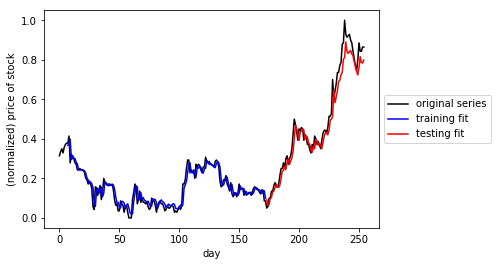

In [28]:
### Plot everything - the original series as well as predictions on training and testing sets
import matplotlib.pyplot as plt
%matplotlib inline

# plot original series
plt.plot(dataset,color = 'k')

# plot training set prediction
split_pt = train_test_split + window_size 
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# plot testing set prediction
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('(normalized) price of stock')
plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Text classification from IMDB dataset

Another task where you can use neural networks is a text classification (or text processing). For this example we are going to use the IMDB dataset, which is also part of Keras. This dataset contains IMDB reviews and tells whether they are positive or negative. Lets load the dataset

In [29]:
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=5000)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
25000 train sequences
25000 test sequences


How does the data look like?

In [30]:
print(x_train[0])
print("label: {}".format(y_train[0]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32]
label: 1


You can see we have received just an array of numbers, nothing else. These are actually indexes of words, where the words are indexed by how most common they are in the whole dataset. So index 4 means that this was the 4th most common word in the dataset. The labels are either 0 or 1.

In [38]:
# Hyperparameters
max_features = 5000
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 2

Because the sequences have different lengths, we need to pad them to be on the same length (400 words in our case). For this Keras has some helper functions:

In [32]:
maxlen = 400
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
x_train shape: (25000, 400)
x_test shape: (25000, 400)


In [35]:
print(x_train[1])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

Now we will define our neural network model:

In [36]:
model = Sequential()

As a firsts layer we will have an Embedding layer. This is a very interesting one, because its purpose is to learn good mathematical representation of the words. But good for what? Well good for our specific task and good for our neural network - in a different neural network or with different data, the Embedding layer will actually learn something else.

In [39]:
# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))

# Dropout layer to avoid overfitting
model.add(Dropout(0.2))

The next layers should learn to capture the relations between the words. For this we can use a dense layer (has many connections, so slow learning), LSTM (also quite slow to learn), or a convolutional layer. This is similar like in the image classification, but we will have just 1D convolution:

![1D Convolution](conv1d.png)

In [40]:
# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))

Next we'll add a couple of standard dense layers and dropouts. Please note that the last layer is just sigmoid layer - we'll have only 0 or 1 as output

In [41]:
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 50)           250000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 400, 50)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 398, 250)          37750     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 250)               0         
__________

Lets train the network, two epochs are quite enough

In [43]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 90s 4ms/step - loss: 0.4034 - acc: 0.8026 - val_loss: 0.3186 - val_acc: 0.8622
Epoch 2/2
25000/25000 [==============================] - 87s 3ms/step - loss: 0.2300 - acc: 0.9066 - val_loss: 0.3030 - val_acc: 0.8730


We can now do some predictions:

In [ ]:
model.predict(x_test[0:5])

In [ ]:
print(y_test[0:5])